In [1]:
from __future__ import print_function

import pickle
import seaborn as sns
import numpy as np
import pandas as pd
import json
import os
import copy
import time
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

import sys
import utils

# Background

Reinforcement learning is one of categories of machine learning method along with unsupervised and supervised learning. In this frame work, we use reward. Maximizing sumation of rewards is set as the main goal, i.e., finding mapping from givne input data to actions that maximize rewards. 

## Q-Learning

In [2]:
%%time

symbols = utils.get_sap_symbols('sap500')
start_date="2012-01-01"
end_date="2017-01-01"
# use Open data
input_data = utils.get_data_list_key(symbols, start_date, end_date, key='Volume')
target_data = utils.get_data('^OEX', start_date, end_date)['Open']

we cound not fetch data from the following companies
['ABBV', 'A', 'APD', 'ALLE', 'CFG', 'COTY', 'CSRA', 'EVHC', 'FB', 'FTV', 'HPE', 'KHC', 'MNK', 'NAVI', 'NWSA', 'NWS', 'PYPL', 'PSX', 'QRVO', 'SYF', 'UA', 'WRK', 'WLTW', 'ZTS']
CPU times: user 7.27 s, sys: 688 ms, total: 7.96 s
Wall time: 5min 9s


In [3]:
input_data.values.shape

(1242, 481)

In [4]:
vol = np.mean(input_data.values, axis=0)
notsym = ['ABBV', 'ALLE', 'CFG', 'COTY', 'CSRA', 'EVHC', 'FB', 'FTV', 'HPE', 'KHC', 'MNK', 'NAVI', 'NWSA', 'NWS', 'NEE', 'PYPL', 'PSX', 'QRVO', 'SYF', 'UA', 'WRK', 'WLTW', 'ZTS']
symbols = [s for s in symbols if s not in notsym]

In [5]:
symvol = zip(symbols, vol)
symvol = sorted(symvol, key=lambda x: x[1], reverse=True)
chosen_symbol = [x[0] for x in symvol[:10]]
chosen_volume = [x[1] for x in symvol[:10]]

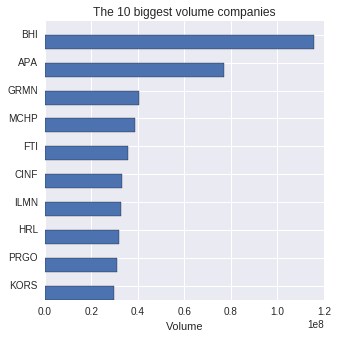

In [78]:
idx = np.arange(len(chosen_symbol))  
height = 0.5

fig, ax = plt.subplots(figsize=[5,5])
_ = ax.barh(idx, chosen_volume[::-1], height)

# add some text for labels, title and axes ticks
ax.set_xlabel('Volume')
ax.set_title('The 10 biggest volume companies')
ax.set_yticks(idx + height)
_ = ax.set_yticklabels(chosen_symbol[::-1])
plt.savefig('10_biggest_volume_companies.jpg')

In [7]:
print(chosen_symbol)

['BHI', 'APA', 'GRMN', 'MCHP', 'FTI', 'CINF', 'ILMN', 'HRL', 'PRGO', 'KORS']


In [8]:
%%time

st = time.time()
symbols = utils.get_sap_symbols('sap500')
start_date="2012-01-01"
end_date="2017-01-01"
# use Open data
input_data = utils.get_data_list_key(chosen_symbol, start_date, end_date)

CPU times: user 596 ms, sys: 92 ms, total: 688 ms
Wall time: 8.29 s


In [9]:
from collections import deque, namedtuple
import numpy as np
from numpy.random import choice

Experiecne = namedtuple('Experience', 'state0,  action, reward, state1')

class RingBuffer(object):
    def __init__(self, maxlen):
        self.maxlen = maxlen
        self.start = 0
        self.length = 0
        # self.data = [None for _ in range(maxlen)]
        self.data = []
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        if idx< 0 or idx >= self.length:
            raise KeyError()
        return self.data[(self.start + idx) % self.maxlen]
    
    def append(self, v):
        if self.length < self.maxlen:
            # We have space, simply increase the length
            self.length += 1
        elif self.length == self.maxlen:
            # No space, "remove" the first item
            self.data[:-1] = self.data[1:]
        else:
            # This should never happen
            raise RuntimeError()
        self.data.append(v)
        
class SequentialMemory(object):
    def __init__(self, limit=1000):
        self.limit = limit
        self.priority = []
        self.actions = RingBuffer(limit)
        self.rewards = RingBuffer(limit)
        self.observations = RingBuffer(limit)
        self.batch_idx = None

        
    def sample(self, batch_size, window_length, alpha=1.0, beta=1.0, epsilon=0.05):
        # udpate priority when sampling
        if len(self.priority) > self.limit:
            self.priority = self.priority[-self.limit:]
        # draw random indexes such that is bigger than window_length to enough length data
        index_space = np.arange(window_length, self.nb_entries)
        # prioritized sample
        p = np.array(self.priority)[window_length:]
        p_tilde = p + np.ones(self.nb_entries - window_length) * np.mean(p) * epsilon
        p_tilde[-1] = np.mean(p)
        p_tilde = p_tilde ** alpha
        p_tilde = p_tilde / np.sum(p_tilde)
        batch_idx = choice(index_space, p=p_tilde, size=batch_size - 1)
        # take the newest data
        batch_idx = np.concatenate((batch_idx, [self.nb_entries - 1]))
        assert len(batch_idx) == batch_size
        # keep batch_idx to update pritority
        self.batch_idx = batch_idx
        
        # weights to modify biased update
        weights = 1. / (p_tilde**beta)
        weights = weights / np.max(weights)
        ret_w = weights[batch_idx - window_length]
        
        # create experiences
        state0 = np.array([[self.observations[i] for i in range(idx - window_length,idx)] for idx in batch_idx])
        action = np.array([self.actions[idx - 1] for idx in batch_idx])
        reward = np.array([self.rewards[idx - 1] for idx in batch_idx])
        state1 = np.array([[self.observations[i] for i in range(idx - window_length + 1,idx + 1)] for idx in batch_idx])
        return Experiecne(state0, action, reward, state1), ret_w
    
    def sample_state(self, batch_size, window_length, alpha=0.5, epsilon=0.05):
        # udpate priority when sampling
        if len(self.priority) > self.limit:
            self.priority = self.priority[-self.limit:]
        # draw random indexes such that is bigger than window_length to enough length data
        index_space = np.arange(window_length, self.nb_entries)
        # prioritized sample
        p = np.array(self.priority)[window_length:]
        p_tilde = p + np.ones(self.nb_entries - window_length) * np.mean(p) * epsilon
        p_tilde[-1] = np.mean(p)
        p_tilde = p_tilde ** alpha
        p_tilde = p_tilde / np.sum(p_tilde)
        batch_idx = choice(index_space, p=p_tilde, size=batch_size - 1)
        # take the newest data
        batch_idx = np.concatenate((batch_idx, [self.nb_entries]))
        assert len(batch_idx) == batch_size
        
        # create experiences
        state = np.array([[self.observations[i] for i in range(idx - window_length,idx)] for idx in batch_idx])
        return state
    
    def sample_state_uniform(self, batch_size, window_length):
        # draw random indexes such that is bigger than window_length to enough length data
        batch_idx = np.random.random_integers(window_length, self.nb_entries - 1, size=batch_size - 1)
        # take the newest data
        batch_idx = np.concatenate((batch_idx, [self.nb_entries]))
        assert len(batch_idx) == batch_size
        
        # create experiences
        state = np.array([[self.observations[i] for i in range(idx - window_length, idx)] for idx in batch_idx])
        return state
    
    def update_priority(self,error):
        for idx, i in enumerate(self.batch_idx):
            self.priority[i] = error[idx]
    
    
    def append(self, observation, action, reward):
        self.observations.append(observation)
        self.actions.append(action)
        self.rewards.append(reward)
        # initialize new sample with 1
        self.priority.append(1.0)
    
    @property
    def nb_entries(self):
        return  len(self.observations)

In [10]:
import warnings

warnings.filterwarnings("ignore")

In [136]:
import tensorflow as tf
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D 
from keras.layers.core import Flatten, Lambda
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers.core import Dense
from keras.engine.topology import Merge
from keras.layers.advanced_activations import PReLU
from keras.layers import SpatialDropout2D
from keras.layers import Dropout
from keras import backend as K
import numpy as np
import pandas as pd
import time
# local library
from memory import SequentialMemory

class DDPG(object):
    """Deep Deterministic Poilicy Gradient
    
    Basend on DDPG and Multiscale CNN, seek out 
    optimal strategy for stock trading.
    
    Available function
    - build_model: build network based on tensorflow and keras
    - train: given DateFrame stock data, train network
    - predict_action: givne DataFrame stock data, return optimal protfolio
    """
    
    def __init__(self, config):
        """initialized approximate value function
        
        config should have the following attributes
        
        Args:
            device: the device to use computation, e.g. '/gpu:0'
            gamma(float): the decay rate for value at RL
            history_length(int): input_length for each scale at CNN
            n_feature(int): the number of type of input 
                (e.g. the number of company to use at stock trading)
            trade_stock_idx(int): trading stock index
            gam (float): discount factor
            n_history(int): the nubmer of history that will be used as input
            n_smooth, n_down(int): the number of smoothed and down sampling input at CNN
            k_w(int): the size of filter at CNN
            n_hidden(int): the size of fully connected layer
            n_batch(int): the size of mini batch
            n_epochs(int): the training epoch for each time
            update_rate (0, 1): parameter for soft update
            learning_rate(float): learning rate for SGD
            memory_length(int): the length of Replay Memory
            n_memory(int): the number of different Replay Memories
            alpha, beta: [0, 1] parameters for Prioritized Replay Memories
            action_scale(float): the scale of initialized ation
        """
        self.device = config.device
        self.save_path = config.save_path
        self.is_load = config.is_load
        self.gamma = config.gamma
        self.history_length = config.history_length
        self.n_stock = config.n_stock
        self.n_smooth = config.n_smooth
        self.n_down = config.n_down
        self.n_batch = config.n_batch
        self.n_epoch = config.n_epoch
        self.update_rate = config.update_rate
        self.alpha = config.alpha
        self.beta = config.beta
        self.lr = config.learning_rate
        self.memory_length = config.memory_length
        self.n_memory = config.n_memory
        self.noise_scale = config.noise_scale
        self.model_config = config.model_config
        # the length of the data as input
        self.n_history = max(self.n_smooth + self.history_length, (self.n_down + 1) * self.history_length)
        print ("building model....")
        # have compatibility with new tensorflow
        tf.python.control_flow_ops = tf
        # avoid creating _LEARNING_PHASE outside the network
        K.clear_session()
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=False))
        K.set_session(self.sess)
        with self.sess.as_default():
            with tf.device(self.device):
                self.build_model()
        print('finished building model!')
    
    def train(self, input_data):
        """training DDPG, where action is confined to integer space
        
        Args:
            data (DataFrame): stock price for self.n_feature companies
        """
        stock_data = input_data.values
        date = input_data.index
        T = len(stock_data)
        
        # frequency for output
        print_freq = int(T / 10)
        if print_freq == 0:
            print_freq = 1
            
        print ("training....")
        st = time.time()
        # prioritizomg parameter
        db = (1 - self.beta) / 1000
        
        # result for return value
        values = []
        date_label = []
        value = 0
        values.append(value)
        date_label.append(date[0])
        # keep half an year data 
        t0 = self.n_history + self.n_batch
        self.initialize_memory(stock_data[:t0])
        plot_freq = 10
        save_freq = 100000
        count = 0
        for t in range(t0, T - 1):
            self.update_memory(stock_data[t], stock_data[t+1])
            reward = self.take_action(stock_data[t], stock_data[t+1])
            value += reward
            date_label.append(date[t+1])
            values.append(value)
            count += 1
            for epoch in range(self.n_epoch):    
                # select transition from pool
                self.update_weight()
                # update prioritizing paramter untill it goes over 1
                # self.beta  += db
                if self.beta >= 1.0:
                    self.beta = 1.0
                 
            if t % print_freq == 0:
                print ("time:",  date[t + 1])
                action = self.predict_action(stock_data[t+1])
                print("portfolio:", action)
                print("reward:", reward)
                print("value:", value)
                print ("elapsed time", time.time() - st)
                print("********************************************************************")
                
            if count % plot_freq == 0:
                result = pd.DataFrame(values, index=pd.DatetimeIndex(date_label))
                result.to_csv("training_result.csv")
                
            if count % save_freq == 0:
                save_path = self.saver.save(self.sess, self.save_path)
                print("Model saved in file: %s" % self.save_path)

        save_path = self.saver.save(self.sess, self.save_path)
        print("Model saved in file: %s" % self.save_path)
        print ("finished training")
           
        return pd.DataFrame(values, index=pd.DatetimeIndex(date_label))
    
    def norm_action(self, action):
        max_action = np.max(np.abs(action))
        if max_action > 1:
            return action / max_action
        else:
            return action
    
    def predict_action(self, state):
        """Preduct Optimal Portfolio
        
        Args:
            state(float): stock data with size: [self.n_stock, ]
        Retrun:
            np.array with size: [self.n_stock, ]
        """
        pred_state = self.memory[0].sample_state_uniform(self.n_batch, self.n_history)
        new_state = pred_state[-1]
        new_state = np.concatenate((new_state[1:], [state]), axis=0)
        pred_state = np.concatenate((pred_state[:-1], [new_state]), axis=0)
        action = self.actor_output.eval(
            session=self.sess,
            feed_dict={self.state: pred_state, K.learning_phase(): 0})[-1]
        # action = self.norm_action(action)
        return action
    
    def update_weight(self):
        # pararel memory update
        idx = np.random.randint(0, self.n_memory)
        experiences, weights = self.memory[idx].sample(self.n_batch, self.n_history, self.alpha, self.beta)
        self.sess.run(self.critic_optim, 
                      feed_dict={self.state: experiences.state0,
                                 self.state_target: experiences.state1,
                                 self.reward: experiences.reward,
                                 self.action: experiences.action,
                                 self.weights: weights,
                                 self.learning_rate: self.lr,
                                 K.learning_phase(): 1})  
        self.sess.run(self.actor_optim,
                      feed_dict={self.state: experiences.state0,
                                 self.learning_rate: self.lr,
                                 K.learning_phase(): 1})  
                
        error = self.sess.run(self.error,
                              feed_dict={self.state: experiences.state0,
                                         self.state_target: experiences.state1,
                                         self.reward: experiences.reward,
                                         self.action: experiences.action,
                                         K.learning_phase(): 0})
        self.memory[idx].update_priority(error)
                    
        # softupdate for critic network
        old_weights = self.critic_target.get_weights()
        new_weights = self.critic.get_weights()
        weights = [self.update_rate * new_w + (1 - self.update_rate) * old_w
                   for new_w, old_w in zip(new_weights, old_weights)]
        self.critic_target.set_weights(weights)
        
    def initialize_memory(self, stocks):
        self.memory = []
        for i in range(self.n_memory):
            self.memory.append(SequentialMemory(self.memory_length))
        for t in range(len(stocks) - 1):
            for idx_memory in range(self.n_memory):
                action = np.random.normal(0, self.noise_scale, self.n_stock)
                action = self.norm_action(action)
                reward = np.sum((stocks[t + 1] - stocks[t]) * action)
                self.memory[idx_memory].append(stocks[t], action, reward)
        
    def update_memory(self, state, state_forward):
        # update memory without updating weight
        for i in range(self.n_memory):
            self.memory[i].observations.append(state)
            self.memory[i].priority.append(1.0)
        # to stabilize batch normalization, use other samples for prediction
        pred_state = self.memory[0].sample_state_uniform(self.n_batch, self.n_history)
        # off policy action and update portfolio
        actor_action = self.actor_output.eval(session=self.sess,
                                      feed_dict={self.state: pred_state,
                                                          K.learning_phase(): 0})[-1]
        action_scale = np.mean(np.abs(actor_action))
        # action_off = np.round(actor_value_off + np.random.normal(0, noise_scale, self.n_stock))
        for i in range(self.n_memory):
            action_off = actor_action + np.random.normal(0, action_scale * self.noise_scale, self.n_stock)
            action_off = self.norm_action(action_off)
            # action_off = actor_value_off
            reward_off = reward = np.sum((state_forward - state) * action_off)
            self.memory[i].rewards.append(reward_off)
            self.memory[i].actions.append(action_off)
       
    def take_action(self, state, state_forward):
        # to stabilize batch normalization, use other samples for prediction
        pred_state = self.memory[0].sample_state_uniform(self.n_batch, self.n_history)
        # off policy action and update portfolio
        action = self.actor_output.eval(session=self.sess,
                                      feed_dict={self.state: pred_state,
                                                          K.learning_phase(): 0})[-1]
        reward = np.sum((state_forward - state) * action)
        return reward
    
    
    def build_model(self):
        """Build all of the network and optimizations
        
        just for conveninece of trainig, seprate placehoder for train and target network
        critic network input: [raw_data, smoothed, downsampled, action]
        actor network input: [raw_data, smoothed, downsampled]
        """
        self.critic = self.build_critic()
        self.critic_target = self.build_critic()
        # actor network input should be [raw_data, smoothed, downsampled]
        self.actor = self.build_actor()
        # transform input into the several scales and smoothing
        self.state =  tf.placeholder(tf.float32, [None, self.n_history, self.n_stock], name='state')
        self.state_target = tf.placeholder(tf.float32, [None, self.n_history, self.n_stock], name='state_target')
        # reshape to convolutional input
        state_ = tf.reshape(self.state, [-1, self.n_history, self.n_stock, 1])
        state_target_ = tf.reshape(self.state_target, [-1, self.n_history, self.n_stock, 1])
        raw, smoothed, down = self.transform_input(state_)
        raw_target, smoothed_target, down_target = self.transform_input(state_target_)
        
        # build graph for citic training
        self.action = tf.placeholder(tf.float32, [None, self.n_stock])
        input_q = [raw,] +  smoothed + down + [self.action,]
        self.Q = tf.squeeze(self.critic(input_q))
        # target network
        # for double q-learning we use actor network not for target network
        self.actor_target_output = self.actor([raw_target,] +  smoothed_target + down_target)
        input_q_target = [raw_target,] +  smoothed_target + down_target + [self.actor_target_output,]
        Q_target = tf.squeeze(self.critic_target(input_q_target))
        self.reward = tf.placeholder(tf.float32, [None], name='reward')
        target = self.reward  + self.gamma * Q_target
        self.target_value = self.reward  + self.gamma * Q_target
        # optimization
        self.learning_rate = tf.placeholder(tf.float32, shape=[], name="learning_rate")
        # get rid of bias of prioritized
        self.weights = tf.placeholder(tf.float32, shape=[None], name="weights")
        self.loss = tf.reduce_mean(self.weights * tf.square(target - self.Q), name='loss')
        # TD-error for priority
        self.error = tf.abs(target - self.Q)
        self.critic_optim = tf.train.AdamOptimizer(self.learning_rate) \
            .minimize(self.loss, var_list=self.critic.trainable_weights)
        
        # build graph for actor training
        self.actor_output = self.actor([raw,] +  smoothed + down)
        input_q_actor = [raw,] +  smoothed + down + [self.actor_output,]
        self.Q_actor = tf.squeeze(self.critic(input_q_actor))
        # optimization
        self.actor_optim = tf.train.AdamOptimizer(self.learning_rate) \
            .minimize(-self.Q_actor, var_list=self.actor.trainable_weights)
        
        self.saver = tf.train.Saver()
        is_initialize = True
        if self.is_load:
            if self.load(self.save_path):
                print('succeded to load')
                is_initialize = False
            else:
                print('failed to load')
        
        # initialize network
        if is_initialize:
            tf.global_variables_initializer().run(session=self.sess)
            weights = self.critic.get_weights()
            self.critic_target.set_weights(weights)
        
    def build_critic(self):
        """Build critic network
        
        recieve convereted tensor: raw_data, smooted_data, and downsampled_data
        """
        # lower layer
        lower_model = [self.build_network(self.model_config['critic_lower'], input_shape=(self.history_length, self.n_stock, 1)) 
                       for _ in range(1  + self.n_smooth + self.n_down)]
        merged = Merge(lower_model, mode='concat')
        # upper layer
        upper_model = self.build_network(self.model_config['critic_upper'],  model=merged)
        # action layer
        action = self.build_network(self.model_config['critic_action'], input_shape=(self.n_stock,), is_conv=False)
        # output layer
        merged = Merge([upper_model, action], mode='mul')
        model = Sequential()
        model.add(merged)
        model.add(Dense(1))
        return model
    
    def build_actor(self):
        """Build actor network
        
        recieve convereted tensor: raw_data, smooted_data, and downsampled_data
        """
        # lower layer
        lower_model = [self.build_network(self.model_config['actor_lower'], input_shape=(self.history_length, self.n_stock, 1)) 
                       for _ in range(1  + self.n_smooth + self.n_down)]
        merged = Merge(lower_model, mode='concat')
        # upper layer
        model = self.build_network(self.model_config['actor_upper'],  model=merged)
        return model
    
    def build_network(self, conf, model=None, input_shape=None, is_conv=True):
        """Build network"""
        _model = model
        model = Sequential()
        if _model is None:
            model.add(Lambda(lambda x: x,  input_shape=input_shape))
        else:
            model.add(_model)
            
        for x in conf:
            if x['is_drop']:
                model.add(Dropout(x['drop_rate']))
            if x['type'] is 'full':
                if is_conv:
                    model.add(Flatten())
                    is_conv = False
                model.add(Dense(x['n_feature']))
            elif x['type'] is 'conv':
                model.add(Convolution2D(nb_filter=x['n_feature'], 
                                        nb_row=x['kw'], 
                                        nb_col=1, 
                                        border_mode='same'))  
                is_conv=True
            if x['is_batch']:
                if x['type'] is 'full':
                    model.add(BatchNormalization(mode=1, axis=-1))
                if x['type'] is 'conv':
                    model.add(BatchNormalization(mode=2, axis=-1))
            model.add(x['activation'])
        return model
    
    
    def transform_input(self, input):
        """Transform data into the Multi Scaled one
        
        Args:
            input: tensor with shape: [None, self.n_history, self.n_stock]
        Return:
            list of the same shape tensors, [None, self.length_history, self.n_stock]
        """
        # the last data is the newest information
        raw = input[:, self.n_history - self.history_length:, :, :]
        # smooth data
        smoothed = []
        for n_sm in range(2, self.n_smooth + 2):
            smoothed.append(
                tf.reduce_mean(tf.pack([input[:, self.n_history - st - self.history_length:self.n_history - st, :, :]
                                        for st in range(n_sm)]),0))
        # downsample data
        down = []
        for n_dw in range(2, self.n_down + 2):
            sampled_ = tf.pack([input[:, idx, :, :] 
                                for idx in range(self.n_history-n_dw*self.history_length, self.n_history, n_dw)])
            down.append(tf.transpose(sampled_, [1, 0, 2, 3]))
        return raw, smoothed, down
    
    def load(self, checkpoint_dir):
        print(" [*] Reading checkpoints...")
        try:
            self.saver.restore(self.sess, self.save_path)
            return True
        except:
            return False

In [138]:
class DDPGConfig(object):
    def __init__(self, n_stock):
        self.device = '/gpu:0'
        self.save_path = '/home/tomoaki/work/github/jjakimoto.github.io/content'
        self.is_load = False
        self.gamma = 1.0
        self.history_length = 10
        self.n_stock = n_stock
        self.n_smooth = 5
        self.n_down = 5
        self.n_batch = 32
        self.n_epoch = 10
        self.update_rate = 1e-1
        self.learning_rate = 1e-3
        self.model_config = {'critic_lower':[{'type':'conv', 'n_feature': 32, 'kw': 4,
                                              'activation': PReLU(), 'is_batch': True, 'is_drop': False},
                                             {'type':'conv', 'n_feature': 64, 'kw': 4,
                                              'activation': PReLU(), 'is_batch': True, 'is_drop': False},
                                             {'type':'conv', 'n_feature': 32, 'kw': 4,
                                              'activation': PReLU(), 'is_batch': True, 'is_drop': False}],
                             'critic_upper':[{'type':'full', 'n_feature': 32, 'kw': 4,
                                              'activation': PReLU(), 'is_batch': True, 'is_drop': False},
                                             {'type':'full', 'n_feature': 10, 'kw': 4,
                                              'activation': Lambda(lambda x: x), 'is_batch': False, 'is_drop': False}],
                             'critic_action':[{'type':'full', 'n_feature': 32, 'kw': 4,
                                              'activation': PReLU(), 'is_batch': True, 'is_drop': False},
                                             {'type':'full', 'n_feature': 10, 'kw': 4,
                                              'activation': PReLU(), 'is_batch': False, 'is_drop': False}],
                             'actor_lower':[{'type':'conv', 'n_feature': 32, 'kw': 4,
                                              'activation': Lambda(lambda x: x), 'is_batch': True, 'is_drop': False},
                                             {'type':'conv', 'n_feature': 64, 'kw': 4,
                                              'activation': PReLU(), 'is_batch': True, 'is_drop': False},
                                             {'type':'conv', 'n_feature': 32, 'kw': 4,
                                              'activation': PReLU(), 'is_batch': True, 'is_drop': False}],
                             'actor_upper':[{'type':'full', 'n_feature': 32, 'kw': 4,
                                              'activation': PReLU(), 'is_batch': True, 'is_drop': False},
                                             {'type':'full', 'n_feature': self.n_stock, 'kw': 4,
                                              'activation': Lambda(lambda x: x), 'is_batch': False, 'is_drop': False}]}
        self.memory_length = 200
        self.n_memory = 10
        self.noise_scale = 5.0
        self.alpha = 0.7
        self.beta = 0.5

In [62]:
n_stock = input_data.shape[-1]

tf.reset_default_graph()

config = DDPGConfig(n_stock)
ddpg = DDPG(config)
values1 = ddpg.train(input_data)

building model....
finished building model!
training....
time: 2012-06-14 00:00:00
portfolio: [ 0.89348048 -0.30346838  1.65462649 -2.21560097 -2.0734036   0.3577202
  0.40750012  0.71212256  1.35833478 -1.12463701]
reward: -1.93706475979
value: -1.93706475979
elapsed time 4.42484807968
********************************************************************
time: 2012-06-15 00:00:00
portfolio: [ 0.89370877  1.61309266  0.65378195 -1.16180122 -1.59655273 -1.9118346
  1.89562511  1.12238777  1.24554384  0.68443817]
reward: -1.40612516389
value: -3.34318992368
elapsed time 6.9808011055
********************************************************************
time: 2012-06-18 00:00:00
portfolio: [ 1.19663608  2.00762582  0.16896446 -1.64428604 -1.65752304 -1.78440475
  2.10324025  1.15622616  0.83627307  0.87000227]
reward: 4.08993394494
value: 0.74674402126
elapsed time 9.59911799431
********************************************************************
time: 2012-06-19 00:00:00
portfolio: [ 1.0059

# 

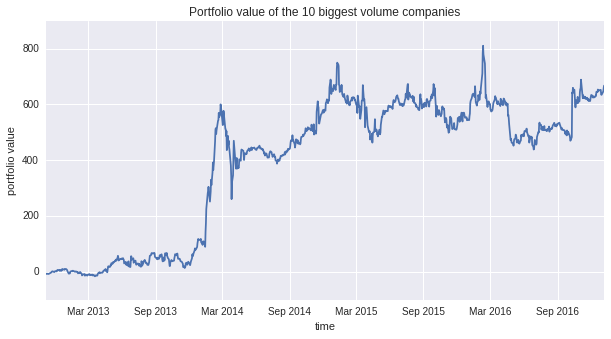

In [87]:
fig, ax = plt.subplots(figsize=[10,5])

# add some text for labels, title and axes ticks
ax.set_xlabel('time')
ax.set_ylabel('portfolio value')
ax.set_title('Portfolio value of the 10 biggest volume companies')
ax.plot(values[100:])
plt.savefig('trade_result.jpg')

In [44]:
!pwd

/home/tomoaki/work/github/jjakimoto.github.io/content


# Vanilla CNN

In [83]:
import tensorflow as tf
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D 
from keras.layers.core import Flatten, Lambda
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers.core import Dense
from keras.engine.topology import Merge
from keras.layers.advanced_activations import PReLU
from keras.layers import SpatialDropout2D
from keras.layers import Dropout
from keras import backend as K
import numpy as np
import pandas as pd
import time
# local library
from memory import SequentialMemory

class DDPG(object):
    """Deep Deterministic Poilicy Gradient
    
    Basend on DDPG and Multiscale CNN, seek out 
    optimal strategy for stock trading.
    
    Available function
    - build_model: build network based on tensorflow and keras
    - train: given DateFrame stock data, train network
    - predict_action: givne DataFrame stock data, return optimal protfolio
    """
    
    def __init__(self, config):
        """initialized approximate value function
        
        config should have the following attributes
        
        Args:
            device: the device to use computation, e.g. '/gpu:0'
            gamma(float): the decay rate for value at RL
            history_length(int): input_length for each scale at CNN
            n_feature(int): the number of type of input 
                (e.g. the number of company to use at stock trading)
            trade_stock_idx(int): trading stock index
            gam (float): discount factor
            n_history(int): the nubmer of history that will be used as input
            n_smooth, n_down(int): the number of smoothed and down sampling input at CNN
            k_w(int): the size of filter at CNN
            n_hidden(int): the size of fully connected layer
            n_batch(int): the size of mini batch
            n_epochs(int): the training epoch for each time
            update_rate (0, 1): parameter for soft update
            learning_rate(float): learning rate for SGD
            memory_length(int): the length of Replay Memory
            n_memory(int): the number of different Replay Memories
            alpha, beta: [0, 1] parameters for Prioritized Replay Memories
            action_scale(float): the scale of initialized ation
        """
        self.device = config.device
        self.save_path = config.save_path
        self.is_load = config.is_load
        self.gamma = config.gamma
        self.history_length = config.history_length
        self.n_stock = config.n_stock
        self.n_smooth = config.n_smooth
        self.n_down = config.n_down
        self.n_batch = config.n_batch
        self.n_epoch = config.n_epoch
        self.update_rate = config.update_rate
        self.alpha = config.alpha
        self.beta = config.beta
        self.lr = config.learning_rate
        self.memory_length = config.memory_length
        self.n_memory = config.n_memory
        self.noise_scale = config.noise_scale
        self.model_config = config.model_config
        # the length of the data as input
        self.n_history = max(self.n_smooth + self.history_length, (self.n_down + 1) * self.history_length)
        print ("building model....")
        # have compatibility with new tensorflow
        tf.python.control_flow_ops = tf
        # avoid creating _LEARNING_PHASE outside the network
        K.clear_session()
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=False))
        K.set_session(self.sess)
        with self.sess.as_default():
            with tf.device(self.device):
                self.build_model()
        print('finished building model!')
    
    def train(self, input_data):
        self.max_action = 100
        """training DDPG, where action is confined to integer space
        
        Args:
            data (DataFrame): stock price for self.n_feature companies
        """
        stock_data = input_data.values
        date = input_data.index
        T = len(stock_data)
        
        # frequency for output
        print_freq = int(T / 10)
        if print_freq == 0:
            print_freq = 1
            
        print ("training....")
        st = time.time()
        # prioritizomg parameter
        db = (1 - self.beta) / 1000
        
        # result for return value
        values = []
        date_label = []
        value = 0
        values.append(value)
        date_label.append(date[0])
        # keep half an year data 
        t0 = self.n_history + self.n_batch
        self.initialize_memory(stock_data[:t0])
        plot_freq = 10
        save_freq = 100000
        count = 0
        for t in range(t0, T - 1):
            self.update_memory(stock_data[t], stock_data[t+1])
            reward = self.take_action(stock_data[t], stock_data[t+1])
            value += reward
            date_label.append(date[t+1])
            values.append(value)
            count += 1
            for epoch in range(self.n_epoch):    
                # select transition from pool
                self.update_weight()
                # update prioritizing paramter untill it goes over 1
                # self.beta  += db
                if self.beta >= 1.0:
                    self.beta = 1.0
                 
            if t % print_freq == 0:
                print ("time:",  date[t + 1])
                action = self.predict_action(stock_data[t+1])
                print("portfolio:", action)
                print("reward:", reward)
                print("value:", value)
                print ("elapsed time", time.time() - st)
                print("********************************************************************")
                
            if count % plot_freq == 0:
                result = pd.DataFrame(values, index=pd.DatetimeIndex(date_label))
                result.to_csv("training_result.csv")
                
            if count % save_freq == 0:
                save_path = self.saver.save(self.sess, self.save_path)
                print("Model saved in file: %s" % self.save_path)

        save_path = self.saver.save(self.sess, self.save_path)
        print("Model saved in file: %s" % self.save_path)
        print ("finished training")
           
        return pd.DataFrame(values, index=pd.DatetimeIndex(date_label))
    
    def norm_action(self, action):
        max_action = np.max(np.abs(action))
        if max_action > 1:
            return action / max_action
        else:
            return action
    
    def predict_action(self, state):
        """Preduct Optimal Portfolio
        
        Args:
            state(float): stock data with size: [self.n_stock, ]
        Retrun:
            np.array with size: [self.n_stock, ]
        """
        pred_state = self.memory[0].sample_state_uniform(self.n_batch, self.n_history)
        new_state = pred_state[-1]
        new_state = np.concatenate((new_state[1:], [state]), axis=0)
        pred_state = np.concatenate((pred_state[:-1], [new_state]), axis=0)
        action = self.actor_output.eval(
            session=self.sess,
            feed_dict={self.state: pred_state, K.learning_phase(): 0})[-1]
        # action = self.norm_action(action)
        return action
    
    def update_weight(self):
        # pararel memory update
        idx = np.random.randint(0, self.n_memory)
        experiences, weights = self.memory[idx].sample(self.n_batch, self.n_history, self.alpha, self.beta)
        self.sess.run(self.critic_optim, 
                      feed_dict={self.state: experiences.state0,
                                 self.state_target: experiences.state1,
                                 self.reward: experiences.reward,
                                 self.action: experiences.action,
                                 self.weights: weights,
                                 self.learning_rate: self.lr,
                                 K.learning_phase(): 1})  
        self.sess.run(self.actor_optim,
                      feed_dict={self.state: experiences.state0,
                                 self.learning_rate: self.lr,
                                 K.learning_phase(): 1})  
                
        error = self.sess.run(self.error,
                              feed_dict={self.state: experiences.state0,
                                         self.state_target: experiences.state1,
                                         self.reward: experiences.reward,
                                         self.action: experiences.action,
                                         K.learning_phase(): 0})
        self.memory[idx].update_priority(error)
                    
        # softupdate for critic network
        old_weights = self.critic_target.get_weights()
        new_weights = self.critic.get_weights()
        weights = [self.update_rate * new_w + (1 - self.update_rate) * old_w
                   for new_w, old_w in zip(new_weights, old_weights)]
        self.critic_target.set_weights(weights)
        
    def initialize_memory(self, stocks):
        self.memory = []
        for i in range(self.n_memory):
            self.memory.append(SequentialMemory(self.memory_length))
        for t in range(len(stocks) - 1):
            for idx_memory in range(self.n_memory):
                action = np.random.normal(0, self.noise_scale, self.n_stock)
                action = self.norm_action(action)
                reward = np.sum((stocks[t + 1] - stocks[t]) * action)
                self.memory[idx_memory].append(stocks[t], action, reward)
        
    def update_memory(self, state, state_forward):
        # update memory without updating weight
        for i in range(self.n_memory):
            self.memory[i].observations.append(state)
            self.memory[i].priority.append(1.0)
        # to stabilize batch normalization, use other samples for prediction
        pred_state = self.memory[0].sample_state_uniform(self.n_batch, self.n_history)
        # off policy action and update portfolio
        actor_action = self.actor_output.eval(session=self.sess,
                                      feed_dict={self.state: pred_state,
                                                          K.learning_phase(): 0})[-1]
        action_scale = np.mean(np.abs(actor_action))
        # action_off = np.round(actor_value_off + np.random.normal(0, noise_scale, self.n_stock))
        for i in range(self.n_memory):
            action_off = actor_action + np.random.normal(0, action_scale * self.noise_scale, self.n_stock)
            action_off = self.norm_action(action_off)
            # action_off = actor_value_off
            reward_off = reward = np.sum((state_forward - state) * action_off)
            self.memory[i].rewards.append(reward_off)
            self.memory[i].actions.append(action_off)
       
    def take_action(self, state, state_forward):
        # to stabilize batch normalization, use other samples for prediction
        pred_state = self.memory[0].sample_state_uniform(self.n_batch, self.n_history)
        # off policy action and update portfolio
        action = self.actor_output.eval(session=self.sess,
                                      feed_dict={self.state: pred_state,
                                                          K.learning_phase(): 0})[-1]
        reward = np.sum((state_forward - state) * action)
        return reward
    
    
    def build_model(self):
        """Build all of the network and optimizations
        
        just for conveninece of trainig, seprate placehoder for train and target network
        critic network input: [raw_data, smoothed, downsampled, action]
        actor network input: [raw_data, smoothed, downsampled]
        """
        self.critic = self.build_critic()
        self.critic_target = self.build_critic()
        # actor network input should be [raw_data, smoothed, downsampled]
        self.actor = self.build_actor()
        # transform input into the several scales and smoothing
        self.state =  tf.placeholder(tf.float32, [None, self.n_history, self.n_stock], name='state')
        self.state_target = tf.placeholder(tf.float32, [None, self.n_history, self.n_stock], name='state_target')
        # reshape to convolutional input
        state_ = tf.reshape(self.state, [-1, self.n_history, self.n_stock, 1])
        state_target_ = tf.reshape(self.state_target, [-1, self.n_history, self.n_stock, 1])
        raw, smoothed, down = self.transform_input(state_)
        raw_target, smoothed_target, down_target = self.transform_input(state_target_)
        
        # build graph for citic training
        self.action = tf.placeholder(tf.float32, [None, self.n_stock])
        input_q = [raw,] +  smoothed + down + [self.action,]
        self.Q = tf.squeeze(self.critic(input_q))
        # target network
        # for double q-learning we use actor network not for target network
        self.actor_target_output = self.actor([raw_target,] +  smoothed_target + down_target)
        input_q_target = [raw_target,] +  smoothed_target + down_target + [self.actor_target_output,]
        Q_target = tf.squeeze(self.critic_target(input_q_target))
        self.reward = tf.placeholder(tf.float32, [None], name='reward')
        target = self.reward  + self.gamma * Q_target
        self.target_value = self.reward  + self.gamma * Q_target
        # optimization
        self.learning_rate = tf.placeholder(tf.float32, shape=[], name="learning_rate")
        # get rid of bias of prioritized
        self.weights = tf.placeholder(tf.float32, shape=[None], name="weights")
        self.loss = tf.reduce_mean(self.weights * tf.square(target - self.Q), name='loss')
        # TD-error for priority
        self.error = tf.abs(target - self.Q)
        self.critic_optim = tf.train.AdamOptimizer(self.learning_rate) \
            .minimize(self.loss, var_list=self.critic.trainable_weights)
        
        # build graph for actor training
        self.actor_output = self.actor([raw,] +  smoothed + down)
        input_q_actor = [raw,] +  smoothed + down + [self.actor_output,]
        self.Q_actor = tf.squeeze(self.critic(input_q_actor))
        # optimization
        self.actor_optim = tf.train.AdamOptimizer(self.learning_rate) \
            .minimize(-self.Q_actor, var_list=self.actor.trainable_weights)
        
        self.saver = tf.train.Saver()
        is_initialize = True
        if self.is_load:
            if self.load(self.save_path):
                print('succeded to load')
                is_initialize = False
            else:
                print('failed to load')
        
        # initialize network
        if is_initialize:
            tf.global_variables_initializer().run(session=self.sess)
            weights = self.critic.get_weights()
            self.critic_target.set_weights(weights)
        
    def build_critic(self):
        """Build critic network
        
        recieve convereted tensor: raw_data, smooted_data, and downsampled_data
        """
        # lower layer
        lower_model = [self.build_network(self.model_config['critic_lower'], input_shape=(self.history_length, self.n_stock, 1)) 
                       for _ in range(1  + self.n_smooth + self.n_down)]
        # merged = Merge(lower_model, mode='concat')
        merged = lower_model[0]
        # upper layer
        upper_model = self.build_network(self.model_config['critic_upper'],  model=merged)
        # action layer
        action = self.build_network(self.model_config['critic_action'], input_shape=(self.n_stock,), is_conv=False)
        # output layer
        merged = Merge([upper_model, action], mode='mul')
        model = Sequential()
        model.add(merged)
        model.add(Dense(1))
        return model
    
    def build_actor(self):
        """Build actor network
        
        recieve convereted tensor: raw_data, smooted_data, and downsampled_data
        """
        # lower layer
        lower_model = [self.build_network(self.model_config['actor_lower'], input_shape=(self.history_length, self.n_stock, 1)) 
                       for _ in range(1  + self.n_smooth + self.n_down)]
        # merged = Merge(lower_model, mode='concat')
        merged = lower_model[0]
        # upper layer
        model = self.build_network(self.model_config['actor_upper'],  model=merged)
        return model
    
    def build_network(self, conf, model=None, input_shape=None, is_conv=True):
        """Build network"""
        _model = model
        model = Sequential()
        if _model is None:
            model.add(Lambda(lambda x: x,  input_shape=input_shape))
        else:
            model.add(_model)
            
        for x in conf:
            if x['is_drop']:
                model.add(Dropout(x['drop_rate']))
            if x['type'] is 'full':
                if is_conv:
                    model.add(Flatten())
                    is_conv = False
                model.add(Dense(x['n_feature']))
            elif x['type'] is 'conv':
                model.add(Convolution2D(nb_filter=x['n_feature'], 
                                        nb_row=x['kw'], 
                                        nb_col=1, 
                                        border_mode='same'))  
                is_conv=True
            if x['is_batch']:
                if x['type'] is 'full':
                    model.add(BatchNormalization(mode=1, axis=-1))
                if x['type'] is 'conv':
                    model.add(BatchNormalization(mode=2, axis=-1))
            model.add(x['activation'])
        return model
    
    
    def transform_input(self, input):
        """Transform data into the Multi Scaled one
        
        Args:
            input: tensor with shape: [None, self.n_history, self.n_stock]
        Return:
            list of the same shape tensors, [None, self.length_history, self.n_stock]
        """
        # the last data is the newest information
        raw = input[:, self.n_history - self.history_length:, :, :]
        # smooth data
        smoothed = []
        for n_sm in range(2, self.n_smooth + 2):
            smoothed.append(
                tf.reduce_mean(tf.pack([input[:, self.n_history - st - self.history_length:self.n_history - st, :, :]
                                        for st in range(n_sm)]),0))
        # downsample data
        down = []
        for n_dw in range(2, self.n_down + 2):
            sampled_ = tf.pack([input[:, idx, :, :] 
                                for idx in range(self.n_history-n_dw*self.history_length, self.n_history, n_dw)])
            down.append(tf.transpose(sampled_, [1, 0, 2, 3]))
        return raw, smoothed, down
    
    def load(self, checkpoint_dir):
        print(" [*] Reading checkpoints...")
        try:
            self.saver.restore(self.sess, self.save_path)
            return True
        except:
            return False

In [91]:
class DDPGCNNConfig(object):
    def __init__(self, n_stock):
        self.device = '/gpu:0'
        self.save_path = '/home/tomoaki/work/github/jjakimoto.github.io/content'
        self.is_load = False
        self.gamma = 1.0
        self.history_length = 10
        self.n_stock = n_stock
        self.n_smooth = 0
        self.n_down = 0
        self.n_batch = 32
        self.n_epoch = 10
        self.update_rate = 1e-1
        self.learning_rate = 1e-3
        self.model_config = {'critic_lower':[{'type':'conv', 'n_feature': 32, 'kw': 4,
                                              'activation': PReLU(), 'is_batch': True, 'is_drop': False},
                                             {'type':'conv', 'n_feature': 64, 'kw': 4,
                                              'activation': PReLU(), 'is_batch': True, 'is_drop': False},
                                             {'type':'conv', 'n_feature': 32, 'kw': 4,
                                              'activation': PReLU(), 'is_batch': True, 'is_drop': False}],
                             
                             'critic_upper':[{'type':'full', 'n_feature': 32, 'kw': 4,
                                              'activation': PReLU(), 'is_batch': True, 'is_drop': False},
                                             {'type':'full', 'n_feature': 10, 'kw': 4,
                                              'activation': Lambda(lambda x: x), 'is_batch': False, 'is_drop': False}],
                             
                             'critic_action':[{'type':'full', 'n_feature': 32, 'kw': 4,
                                              'activation': PReLU(), 'is_batch': True, 'is_drop': False},
                                             {'type':'full', 'n_feature': 10, 'kw': 4,
                                              'activation': PReLU(), 'is_batch': False, 'is_drop': False}],
                             
                             'actor_lower':[{'type':'conv', 'n_feature': 32, 'kw': 4,
                                              'activation': Lambda(lambda x: x), 'is_batch': True, 'is_drop': False},
                                             {'type':'conv', 'n_feature': 64, 'kw': 4,
                                              'activation': PReLU(), 'is_batch': True, 'is_drop': False},
                                             {'type':'conv', 'n_feature': 32, 'kw': 4,
                                              'activation': PReLU(), 'is_batch': True, 'is_drop': False}],
                             
                             'actor_upper':[{'type':'full', 'n_feature': 32, 'kw': 4,
                                              'activation': PReLU(), 'is_batch': True, 'is_drop': False},
                                             {'type':'full', 'n_feature': self.n_stock, 'kw': 4,
                                              'activation': Lambda(lambda x: x), 'is_batch': False, 'is_drop': False}]}
        self.memory_length = 200
        self.n_memory = 10
        self.noise_scale = 5.0
        self.alpha = 0.7
        self.beta = 0.5

In [118]:
%%time

n_stock = input_data.shape[-1]

tf.reset_default_graph()

config = DDPGCNNConfig(n_stock)
ddpg = DDPG(config)
cnn_values2 = ddpg.train(input_data)

building model....
finished building model!
training....
time: 2012-07-31 00:00:00
portfolio: [-0.03913374 -0.91887033  0.5184018  -0.12685449 -0.59295666 -0.23987383
 -0.34422696  1.25914991  0.2034056  -0.43910113]
reward: 1.18397626196
value: -3.06377523765
elapsed time 33.709474802
********************************************************************
time: 2013-01-30 00:00:00
portfolio: [ 0.04826204  0.20928162  1.70293081  0.75032288  0.36547416 -0.944166
 -0.10549973  0.19436602 -0.79491764  0.49212626]
reward: 2.41513507789
value: -41.9450635471
elapsed time 84.6859998703
********************************************************************
time: 2013-07-29 00:00:00
portfolio: [-2.66725612 -4.2058692   4.23407221  0.41498372 -5.65547609  0.32549876
  5.25399637 -1.49599516 -6.0424757   6.27455091]
reward: 29.0151960127
value: -7.11667210887
elapsed time 135.178371906
********************************************************************
time: 2014-01-24 00:00:00
portfolio: [-0.06544

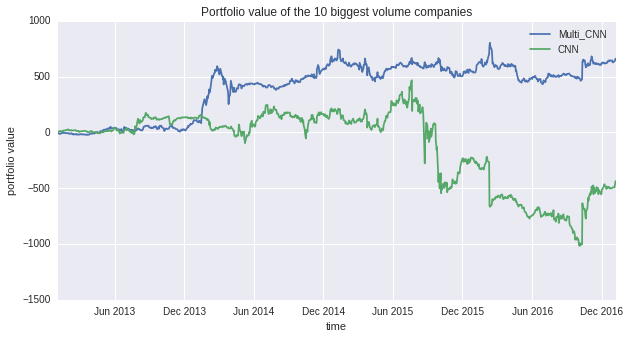

In [119]:
fig, ax = plt.subplots(figsize=[10,5])

# add some text for labels, title and axes ticks
st = pd.Timestamp("2013-01-01")
values_tilde = values.loc[values.index >= st]
cnn_values_tilde = cnn_values2.loc[cnn_values2.index >= st]
ax.set_xlabel('time')
ax.set_ylabel('portfolio value')
ax.set_title('Portfolio value of the 10 biggest volume companies')
ax.plot(values_tilde.index, values_tilde.values - values_tilde.values[0], label='Multi_CNN')
ax.plot(cnn_values_tilde.index, cnn_values_tilde.values - cnn_values_tilde.values[0], label='CNN')
ax.legend()
# plt.savefig('trade_result.jpg')

# Random Trade

In [102]:
plt.plot(values_tilde.index

DatetimeIndex(['2013-01-02', '2013-01-03', '2013-01-04', '2013-01-07',
               '2013-01-08', '2013-01-09', '2013-01-10', '2013-01-11',
               '2013-01-14', '2013-01-15',
               ...
               '2016-12-22', '2016-12-23', '2016-12-27', '2016-12-28',
               '2016-12-29', '2016-12-30', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06'],
              dtype='datetime64[ns]', length=1012, freq=None)

In [161]:
def random_trade(data, n_stock, scale=1):
    val = data.values
    n_data = len(val)
    portfolio = np.random.normal(loc=0.0, scale=scale, size=(n_data - 1, n_stock))
    diff = val[1:] - val[:-1]
    port_val = np.sum(diff*portfolio, axis=-1)
    return pd.DataFrame(np.cumsum(port_val), index=data.index[1:])

In [194]:
random_val_list = []
for i in range(10):
    random_val_list.append(random_trade(input_data, n_stock=n_stock, scale=5))

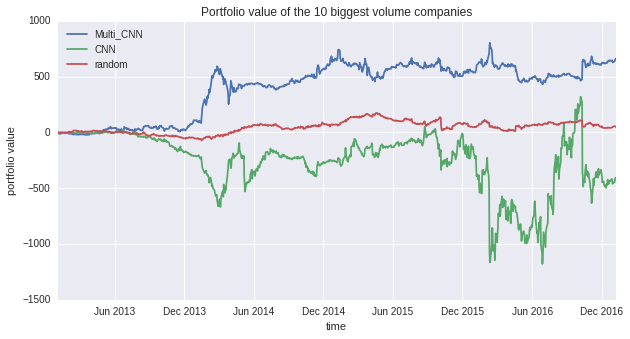

In [178]:
fig, ax = plt.subplots(figsize=[10,5])

# add some text for labels, title and axes ticks
st = pd.Timestamp("2013-01-01")
values_tilde = values.loc[values.index >= st]
cnn_values_tilde = cnn_values1.loc[cnn_values1.index >= st]
random_val_tilde = random_val.loc[random_val.index >= st]
ax.set_xlabel('time')
ax.set_ylabel('portfolio value')
ax.set_title('Portfolio value of the 10 biggest volume companies')
ax.plot(values_tilde.index, values_tilde.values - values_tilde.values[0], label='Multi_CNN')
ax.plot(cnn_values_tilde.index, cnn_values_tilde.values - cnn_values_tilde.values[0], label='CNN')
ax.plot(random_val_tilde.index, random_val_tilde.values - random_val_tilde.values[0], label='random')
ax.legend(loc='upper left')
plt.savefig('trade_result.jpg')

# 10 samples

In [120]:
%%time

n_stock = input_data.shape[-1]
n_sample = 10

cnn_val_list = []
for i in range(n_sample):
    tf.reset_default_graph()
    config = DDPGCNNConfig(n_stock)
    ddpg = DDPG(config)
    cnn_val_list.append(ddpg.train(input_data))

building model....
finished building model!
training....
time: 2012-07-31 00:00:00
portfolio: [-1.09910548  0.65448463 -1.04541683  1.22367299 -0.03251517 -0.18706056
 -0.052321    1.29890859  0.36152202  1.12391937]
reward: -2.22745419995
value: -1.17133136401
elapsed time 33.205026865
********************************************************************
time: 2013-01-30 00:00:00
portfolio: [ 0.97729564 -0.10238083 -1.0744071  -2.53471541 -0.36033189  0.39760941
 -1.83203077 -0.36287186 -0.40270522 -1.76003778]
reward: 1.43672408252
value: -1.63894430863
elapsed time 81.9664430618
********************************************************************
time: 2013-07-29 00:00:00
portfolio: [ 0.1748589   0.20953244 -0.01330548 -0.75387508 -0.25051418 -1.55462778
 -0.1774061  -0.06992207  0.29252657 -0.28578576]
reward: -1.07712292719
value: -38.3867249435
elapsed time 129.857926846
********************************************************************
time: 2014-01-24 00:00:00
portfolio: [-0.4

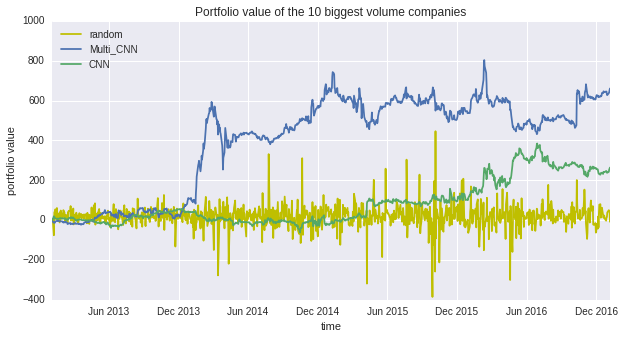

In [143]:
fig, ax = plt.subplots(figsize=[10,5])

# add some text for labels, title and axes ticks
st = pd.Timestamp("2013-01-01")
values_tilde = values.loc[values.index >= st]
cnn_values_tilde = cnn_val_list[3].loc[cnn_val_list[3].index >= st]
random_val_tilde = random_val.loc[random_val.index >= st]
ax.set_xlabel('time')
ax.set_ylabel('portfolio value')
ax.set_title('Portfolio value of the 10 biggest volume companies')
ax.plot(random_val_tilde.index, random_val_tilde.values - random_val_tilde.values[0], label='random', color='y')
ax.plot(values_tilde.index, values_tilde.values - values_tilde.values[0], label='Multi_CNN')
ax.plot(cnn_values_tilde.index, cnn_values_tilde.values - cnn_values_tilde.values[0], label='CNN')
ax.legend(loc='upper left')
plt.savefig('trade_result.jpg')

In [133]:
cnn_mean = []
for x in cnn_val_list:
    cnn_mean.append(x.values)
cnn_mean = np.mean(np.array(cnn_mean), axis=0)
cnn_mean = pd.DataFrame(cnn_mean, index=cnn_val_list[0].index)

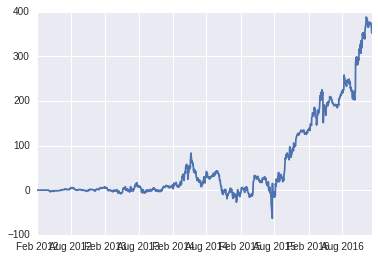

In [134]:
plt.plot(cnn_mean)

In [132]:
cnn_val_list[0].values.shape

(1200, 1)

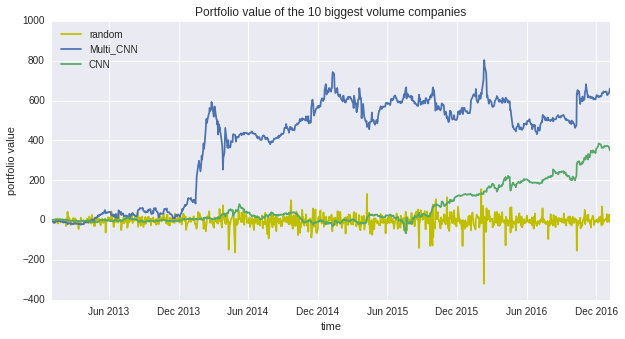

In [135]:
fig, ax = plt.subplots(figsize=[10,5])

# add some text for labels, title and axes ticks
st = pd.Timestamp("2013-01-01")
values_tilde = values.loc[values.index >= st]
cnn_values_tilde = cnn_mean.loc[cnn_mean.index >= st]
random_val_tilde = random_val.loc[random_val.index >= st]
ax.set_xlabel('time')
ax.set_ylabel('portfolio value')
ax.set_title('Portfolio value of the 10 biggest volume companies')
ax.plot(random_val_tilde.index, random_val_tilde.values - random_val_tilde.values[0], label='random', color='y')
ax.plot(values_tilde.index, values_tilde.values - values_tilde.values[0], label='Multi_CNN')
ax.plot(cnn_values_tilde.index, cnn_values_tilde.values - cnn_values_tilde.values[0], label='CNN')
ax.legend(loc='upper left')
plt.savefig('mean_result.jpg')

In [146]:
%%time
n_stock = input_data.shape[-1]
n_sample = 10

multi_val_list = []
for i in range(n_sample):
    print('__________________________________________')
    print("%d th" %(i+1))
    print('__________________________________________')
    tf.reset_default_graph()
    config = DDPGConfig(n_stock)
    ddpg = DDPG(config)
    multi_val_list.append(ddpg.train(input_data))

__________________________________________
1 th
__________________________________________
building model....
finished building model!
training....
time: 2012-07-31 00:00:00
portfolio: [-0.00762923  0.21727054  0.28420576  0.08107086  0.10634653 -0.10878231
 -0.25534248  0.07919216 -0.42814091 -0.0689296 ]
reward: 0.290865226924
value: -12.3009235556
elapsed time 86.8773841858
********************************************************************
time: 2013-01-30 00:00:00
portfolio: [-0.49633098 -0.85680884  0.69738889 -0.37014505 -0.40783286 -0.22999933
 -0.84139514  0.59318793 -0.62890875 -0.37641266]
reward: 0.524062763602
value: -16.7298958401
elapsed time 403.406014204
********************************************************************
time: 2013-07-29 00:00:00
portfolio: [-0.03366634 -2.97032309 -1.06810236 -1.15498483 -2.64309335 -1.50088263
 -0.24244404  1.50643969  1.08059525 -0.65185785]
reward: 1.6931083354
value: -62.8677056175
elapsed time 719.488464117
********************

In [184]:
def get_mean(list_data, st=pd.Timestamp("2013-01-01")):
    value = []
    for x in list_data:
        x_tilde = x.loc[x.index >= st]
        index = x_tilde.index
        x_val = x_tilde.values
        value.append(x_val - x_val[0])
    return pd.DataFrame(np.mean(np.array(value), axis=0), index=index)

In [196]:
cnn_mean = get_mean(cnn_val_list, st=pd.Timestamp("2015-01-01"))
multi_mean = get_mean(multi_val_list, st=pd.Timestamp("2015-01-01"))
random_mean = get_mean(random_val_list, st=pd.Timestamp("2015-01-01"))

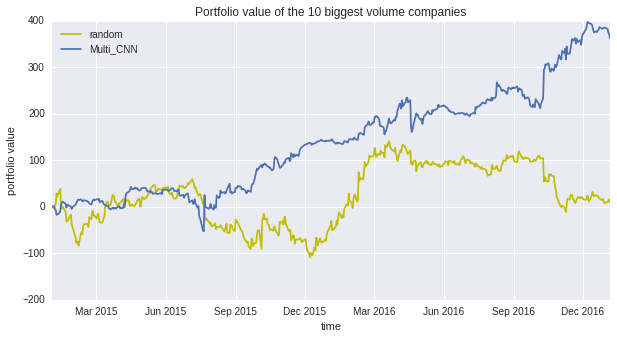

In [197]:
fig, ax = plt.subplots(figsize=[10,5])

# add some text for labels, title and axes ticks
st = pd.Timestamp("2013-01-01")
values_tilde = multi_val_list[4].loc[multi_val_list[6].index >= st]
cnn_values_tilde = cnn_mean.loc[cnn_mean.index >= st]
random_val_tilde = random_val.loc[random_val.index >= st]
ax.set_xlabel('time')
ax.set_ylabel('portfolio value')
ax.set_title('Portfolio value of the 10 biggest volume companies')
ax.plot(random_mean, label='random', color='y')
# ax.plot(multi_mean, label='Multi_CNN')
ax.plot(cnn_mean, label='Multi_CNN')
ax.legend(loc='upper left')
plt.savefig('mean_result.jpg')

# change architecture

In [210]:
import tensorflow as tf
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D 
from keras.layers.core import Flatten, Lambda
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers.core import Dense
from keras.engine.topology import Merge
from keras.layers.advanced_activations import PReLU
from keras.layers import SpatialDropout2D
from keras.layers import Dropout
from keras import backend as K
import numpy as np
import pandas as pd
import time
# local library
from memory import SequentialMemory

class DDPG(object):
    """Deep Deterministic Poilicy Gradient
    
    Basend on DDPG and Multiscale CNN, seek out 
    optimal strategy for stock trading.
    
    Available function
    - build_model: build network based on tensorflow and keras
    - train: given DateFrame stock data, train network
    - predict_action: givne DataFrame stock data, return optimal protfolio
    """
    
    def __init__(self, config):
        """initialized approximate value function
        
        config should have the following attributes
        
        Args:
            device: the device to use computation, e.g. '/gpu:0'
            gamma(float): the decay rate for value at RL
            history_length(int): input_length for each scale at CNN
            n_feature(int): the number of type of input 
                (e.g. the number of company to use at stock trading)
            trade_stock_idx(int): trading stock index
            gam (float): discount factor
            n_history(int): the nubmer of history that will be used as input
            n_smooth, n_down(int): the number of smoothed and down sampling input at CNN
            k_w(int): the size of filter at CNN
            n_hidden(int): the size of fully connected layer
            n_batch(int): the size of mini batch
            n_epochs(int): the training epoch for each time
            update_rate (0, 1): parameter for soft update
            learning_rate(float): learning rate for SGD
            memory_length(int): the length of Replay Memory
            n_memory(int): the number of different Replay Memories
            alpha, beta: [0, 1] parameters for Prioritized Replay Memories
            action_scale(float): the scale of initialized ation
        """
        self.device = config.device
        self.save_path = config.save_path
        self.is_load = config.is_load
        self.gamma = config.gamma
        self.history_length = config.history_length
        self.n_stock = config.n_stock
        self.n_smooth = config.n_smooth
        self.n_down = config.n_down
        self.n_batch = config.n_batch
        self.n_epoch = config.n_epoch
        self.update_rate = config.update_rate
        self.alpha = config.alpha
        self.beta = config.beta
        self.lr = config.learning_rate
        self.memory_length = config.memory_length
        self.n_memory = config.n_memory
        self.noise_scale = config.noise_scale
        self.model_config = config.model_config
        # the length of the data as input
        self.n_history = max(self.n_smooth + self.history_length, (self.n_down + 1) * self.history_length)
        print ("building model....")
        # have compatibility with new tensorflow
        tf.python.control_flow_ops = tf
        # avoid creating _LEARNING_PHASE outside the network
        K.clear_session()
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=False))
        K.set_session(self.sess)
        with self.sess.as_default():
            with tf.device(self.device):
                self.build_model()
        print('finished building model!')
    
    def train(self, input_data):
        """training DDPG, where action is confined to integer space
        
        Args:
            data (DataFrame): stock price for self.n_feature companies
        """
        stock_data = input_data.values
        date = input_data.index
        T = len(stock_data)
        
        # frequency for output
        print_freq = int(T / 10)
        if print_freq == 0:
            print_freq = 1
        # print_freq = 1
            
        print ("training....")
        st = time.time()
        # prioritizomg parameter
        db = (1 - self.beta) / 1000
        
        # result for return value
        values = []
        date_label = []
        value = 0
        values.append(value)
        date_label.append(date[0])
        # keep half an year data 
        t0 = self.n_history + self.n_batch
        self.initialize_memory(stock_data[:t0])
        plot_freq = 10
        save_freq = 100000
        count = 0
        for t in range(t0, T - 1):
            self.update_memory(stock_data[t], stock_data[t+1])
            reward = self.take_action(stock_data[t], stock_data[t+1])
            value += reward
            date_label.append(date[t+1])
            values.append(value)
            count += 1
            for epoch in range(self.n_epoch):    
                # select transition from pool
                self.update_weight()
                # update prioritizing paramter untill it goes over 1
                # self.beta  += db
                if self.beta >= 1.0:
                    self.beta = 1.0
                 
            if t % print_freq == 0:
                print ("time:",  date[t + 1])
                action = self.predict_action(stock_data[t+1])
                print("portfolio:", action)
                print("reward:", reward)
                print("value:", value)
                print ("elapsed time", time.time() - st)
                print("********************************************************************")
                
            if count % plot_freq == 0:
                result = pd.DataFrame(values, index=pd.DatetimeIndex(date_label))
                result.to_csv("training_result.csv")
                
            if count % save_freq == 0:
                save_path = self.saver.save(self.sess, self.save_path)
                print("Model saved in file: %s" % self.save_path)

        save_path = self.saver.save(self.sess, self.save_path)
        print("Model saved in file: %s" % self.save_path)
        print ("finished training")
           
        return pd.DataFrame(values, index=pd.DatetimeIndex(date_label))
    
    def norm_action(self, action):
        max_action = np.max(np.abs(action))
        if max_action > 1:
            return action / max_action
        else:
            return action
    
    def predict_action(self, state):
        """Preduct Optimal Portfolio
        
        Args:
            state(float): stock data with size: [self.n_stock, ]
        Retrun:
            np.array with size: [self.n_stock, ]
        """
        pred_state = self.memory[0].sample_state_uniform(self.n_batch, self.n_history)
        new_state = pred_state[-1]
        new_state = np.concatenate((new_state[1:], [state]), axis=0)
        pred_state = np.concatenate((pred_state[:-1], [new_state]), axis=0)
        action = self.actor_output.eval(
            session=self.sess,
            feed_dict={self.state: pred_state, K.learning_phase(): 0})[-1]
        # action = self.norm_action(action)
        return action
    
    def update_weight(self):
        # pararel memory update
        idx = np.random.randint(0, self.n_memory)
        experiences, weights = self.memory[idx].sample(self.n_batch, self.n_history, self.alpha, self.beta)
        self.sess.run(self.critic_optim, 
                      feed_dict={self.state: experiences.state0,
                                 self.state_target: experiences.state1,
                                 self.reward: experiences.reward,
                                 self.action: experiences.action,
                                 self.weights: weights,
                                 self.learning_rate: self.lr,
                                 K.learning_phase(): 1})  
        self.sess.run(self.actor_optim,
                      feed_dict={self.state: experiences.state0,
                                 self.learning_rate: self.lr,
                                 K.learning_phase(): 1})  
                
        error = self.sess.run(self.error,
                              feed_dict={self.state: experiences.state0,
                                         self.state_target: experiences.state1,
                                         self.reward: experiences.reward,
                                         self.action: experiences.action,
                                         K.learning_phase(): 0})
        self.memory[idx].update_priority(error)
                    
        # softupdate for critic network
        old_weights = self.critic_target.get_weights()
        new_weights = self.critic.get_weights()
        weights = [self.update_rate * new_w + (1 - self.update_rate) * old_w
                   for new_w, old_w in zip(new_weights, old_weights)]
        self.critic_target.set_weights(weights)
        
    def initialize_memory(self, stocks):
        self.memory = []
        for i in range(self.n_memory):
            self.memory.append(SequentialMemory(self.memory_length))
        for t in range(len(stocks) - 1):
            for idx_memory in range(self.n_memory):
                action = np.random.normal(0, self.noise_scale, self.n_stock)
                action = self.norm_action(action)
                reward = np.sum((stocks[t + 1] - stocks[t]) * action)
                self.memory[idx_memory].append(stocks[t], action, reward)
        
    def update_memory(self, state, state_forward):
        # update memory without updating weight
        for i in range(self.n_memory):
            self.memory[i].observations.append(state)
            self.memory[i].priority.append(1.0)
        # to stabilize batch normalization, use other samples for prediction
        pred_state = self.memory[0].sample_state_uniform(self.n_batch, self.n_history)
        # off policy action and update portfolio
        actor_action = self.actor_output.eval(session=self.sess,
                                      feed_dict={self.state: pred_state,
                                                          K.learning_phase(): 0})[-1]
        action_scale = np.mean(np.abs(actor_action))
        # action_off = np.round(actor_value_off + np.random.normal(0, noise_scale, self.n_stock))
        for i in range(self.n_memory):
            action_off = actor_action + np.random.normal(0, action_scale * self.noise_scale, self.n_stock)
            action_off = self.norm_action(action_off)
            # action_off = actor_value_off
            reward_off = reward = np.sum((state_forward - state) * action_off)
            self.memory[i].rewards.append(reward_off)
            self.memory[i].actions.append(action_off)
       
    def take_action(self, state, state_forward):
        # to stabilize batch normalization, use other samples for prediction
        pred_state = self.memory[0].sample_state_uniform(self.n_batch, self.n_history)
        # off policy action and update portfolio
        action = self.actor_output.eval(session=self.sess,
                                      feed_dict={self.state: pred_state,
                                                          K.learning_phase(): 0})[-1]
        reward = np.sum((state_forward - state) * action)
        return reward
    
    
    def build_model(self):
        """Build all of the network and optimizations
        
        just for conveninece of trainig, seprate placehoder for train and target network
        critic network input: [raw_data, smoothed, downsampled, action]
        actor network input: [raw_data, smoothed, downsampled]
        """
        self.critic = self.build_critic()
        self.critic_target = self.build_critic()
        # actor network input should be [raw_data, smoothed, downsampled]
        self.actor = self.build_actor()
        # transform input into the several scales and smoothing
        self.state =  tf.placeholder(tf.float32, [None, self.n_history, self.n_stock], name='state')
        self.state_target = tf.placeholder(tf.float32, [None, self.n_history, self.n_stock], name='state_target')
        # reshape to convolutional input
        state_ = tf.reshape(self.state, [-1, self.n_history, self.n_stock, 1])
        state_target_ = tf.reshape(self.state_target, [-1, self.n_history, self.n_stock, 1])
        raw, smoothed, down = self.transform_input(state_)
        raw_target, smoothed_target, down_target = self.transform_input(state_target_)
        
        # build graph for citic training
        self.action = tf.placeholder(tf.float32, [None, self.n_stock])
        input_q = [raw,] +  smoothed + down + [self.action,]
        self.Q = tf.squeeze(self.critic(input_q))
        # target network
        # for double q-learning we use actor network not for target network
        self.actor_target_output = self.actor([raw_target,] +  smoothed_target + down_target)
        input_q_target = [raw_target,] +  smoothed_target + down_target + [self.actor_target_output,]
        Q_target = tf.squeeze(self.critic_target(input_q_target))
        self.reward = tf.placeholder(tf.float32, [None], name='reward')
        target = self.reward  + self.gamma * Q_target
        self.target_value = self.reward  + self.gamma * Q_target
        # optimization
        self.learning_rate = tf.placeholder(tf.float32, shape=[], name="learning_rate")
        # get rid of bias of prioritized
        self.weights = tf.placeholder(tf.float32, shape=[None], name="weights")
        self.loss = tf.reduce_mean(self.weights * tf.square(target - self.Q), name='loss')
        # TD-error for priority
        self.error = tf.abs(target - self.Q)
        self.critic_optim = tf.train.AdamOptimizer(self.learning_rate) \
            .minimize(self.loss, var_list=self.critic.trainable_weights)
        
        # build graph for actor training
        self.actor_output = self.actor([raw,] +  smoothed + down)
        input_q_actor = [raw,] +  smoothed + down + [self.actor_output,]
        self.Q_actor = tf.squeeze(self.critic(input_q_actor))
        # optimization
        self.actor_optim = tf.train.AdamOptimizer(self.learning_rate) \
            .minimize(-self.Q_actor, var_list=self.actor.trainable_weights)
        
        self.saver = tf.train.Saver()
        is_initialize = True
        if self.is_load:
            if self.load(self.save_path):
                print('succeded to load')
                is_initialize = False
            else:
                print('failed to load')
        
        # initialize network
        if is_initialize:
            tf.global_variables_initializer().run(session=self.sess)
            weights = self.critic.get_weights()
            self.critic_target.set_weights(weights)
        
    def build_critic(self):
        """Build critic network
        
        recieve convereted tensor: raw_data, smooted_data, and downsampled_data
        """
        # lower layer
        lower_model = [self.build_network(self.model_config['critic_lower'], input_shape=(self.history_length, self.n_stock, 1)) 
                       for _ in range(1  + self.n_smooth + self.n_down)]
        # merged = Merge(lower_model, mode='concat')
        # action layer
        # action = self.build_network(self.model_config['critic_action'], input_shape=(self.n_stock,), is_conv=False)
        for x in lower_model:
            x.add(Flatten())
        action = Sequential()
        action.add(Lambda(lambda x: x,  input_shape=(self.n_stock,)))
        # output layer
        merged = Merge(lower_model + [action, ], mode='concat')
        # upper layer
        model = self.build_network(self.model_config['critic_upper'],  model=merged, is_conv=False)
        return model
    
    def build_actor(self):
        """Build actor network
        
        recieve convereted tensor: raw_data, smooted_data, and downsampled_data
        """
        # lower layer
        lower_model = [self.build_network(self.model_config['actor_lower'], input_shape=(self.history_length, self.n_stock, 1)) 
                       for _ in range(1  + self.n_smooth + self.n_down)]
        merged = Merge(lower_model, mode='concat')
        # upper layer
        model = self.build_network(self.model_config['actor_upper'],  model=merged)
        return model
    
    def build_network(self, conf, model=None, input_shape=None, is_conv=True):
        """Build network"""
        _model = model
        model = Sequential()
        if _model is None:
            model.add(Lambda(lambda x: x,  input_shape=input_shape))
        else:
            model.add(_model)
            
        for x in conf:
            if x['is_drop']:
                model.add(Dropout(x['drop_rate']))
            if x['type'] is 'full':
                if is_conv:
                    model.add(Flatten())
                    is_conv = False
                model.add(Dense(x['n_feature']))
            elif x['type'] is 'conv':
                model.add(Convolution2D(nb_filter=x['n_feature'], 
                                        nb_row=x['kw'], 
                                        nb_col=1, 
                                        border_mode='same'))  
                is_conv=True
            if x['is_batch']:
                if x['type'] is 'full':
                    model.add(BatchNormalization(mode=1, axis=-1))
                if x['type'] is 'conv':
                    model.add(BatchNormalization(mode=2, axis=-1))
            model.add(x['activation'])
        return model
    
    
    def transform_input(self, input):
        """Transform data into the Multi Scaled one
        
        Args:
            input: tensor with shape: [None, self.n_history, self.n_stock]
        Return:
            list of the same shape tensors, [None, self.length_history, self.n_stock]
        """
        # the last data is the newest information
        raw = input[:, self.n_history - self.history_length:, :, :]
        # smooth data
        smoothed = []
        for n_sm in range(2, self.n_smooth + 2):
            smoothed.append(
                tf.reduce_mean(tf.pack([input[:, self.n_history - st - self.history_length:self.n_history - st, :, :]
                                        for st in range(n_sm)]),0))
        # downsample data
        down = []
        for n_dw in range(2, self.n_down + 2):
            sampled_ = tf.pack([input[:, idx, :, :] 
                                for idx in range(self.n_history-n_dw*self.history_length, self.n_history, n_dw)])
            down.append(tf.transpose(sampled_, [1, 0, 2, 3]))
        return raw, smoothed, down
    
    def load(self, checkpoint_dir):
        print(" [*] Reading checkpoints...")
        try:
            self.saver.restore(self.sess, self.save_path)
            return True
        except:
            return False

In [211]:
class DDPGConfig(object):
    def __init__(self, n_stock):
        self.device = '/gpu:0'
        self.save_path = '/home/tomoaki/work/github/jjakimoto.github.io/content'
        self.is_load = False
        self.gamma = 1.0
        self.history_length = 10
        self.n_stock = n_stock
        self.n_smooth = 5
        self.n_down = 5
        self.n_batch = 32
        self.n_epoch = 10
        self.update_rate = 1e-1
        self.learning_rate = 1e-2
        self.model_config = {'critic_lower':[{'type':'conv', 'n_feature': 32, 'kw': 4,
                                              'activation': PReLU(), 'is_batch': True, 'is_drop': False},
                                             {'type':'conv', 'n_feature': 64, 'kw': 4,
                                              'activation': PReLU(), 'is_batch': True, 'is_drop': False},
                                             {'type':'conv', 'n_feature': 32, 'kw': 4,
                                              'activation': PReLU(), 'is_batch': True, 'is_drop': False}],
                             'critic_upper':[{'type':'full', 'n_feature': 32, 'kw': 4,
                                              'activation': PReLU(), 'is_batch': True, 'is_drop': False},
                                             {'type':'full', 'n_feature': 1, 'kw': 4,
                                              'activation': Lambda(lambda x: x), 'is_batch': False, 'is_drop': False}],
                             'critic_action':[{'type':'full', 'n_feature': 32, 'kw': 4,
                                              'activation': PReLU(), 'is_batch': True, 'is_drop': False},
                                             {'type':'full', 'n_feature': 10, 'kw': 4,
                                              'activation': PReLU(), 'is_batch': False, 'is_drop': False}],
                             'actor_lower':[{'type':'conv', 'n_feature': 32, 'kw': 4,
                                              'activation': Lambda(lambda x: x), 'is_batch': True, 'is_drop': False},
                                             {'type':'conv', 'n_feature': 64, 'kw': 4,
                                              'activation': PReLU(), 'is_batch': True, 'is_drop': False},
                                             {'type':'conv', 'n_feature': 32, 'kw': 4,
                                              'activation': PReLU(), 'is_batch': True, 'is_drop': False}],
                             'actor_upper':[{'type':'full', 'n_feature': 32, 'kw': 4,
                                              'activation': PReLU(), 'is_batch': True, 'is_drop': False},
                                             {'type':'full', 'n_feature': self.n_stock, 'kw': 4,
                                              'activation': Lambda(lambda x: x), 'is_batch': False, 'is_drop': False}]}
        self.memory_length = 200
        self.n_memory = 10
        self.noise_scale = 1.0
        self.alpha = 0.7
        self.beta = 0.5

In [212]:
%%time
n_stock = input_data.shape[-1]
n_sample = 10

multi_val_list2 = []
for i in range(n_sample):
    print('__________________________________________')
    print("%d th" %(i+1))
    print('__________________________________________')
    tf.reset_default_graph()
    config = DDPGConfig(n_stock)
    ddpg = DDPG(config)
    multi_val_list2.append(ddpg.train(input_data))

__________________________________________
1 th
__________________________________________
building model....
finished building model!
training....
time: 2012-07-31 00:00:00
portfolio: [-1371.71374512  -636.90692139 -1831.44445801  -599.53198242  -789.6729126
  -348.14257812  1001.96673584 -1973.76318359   970.86364746 -1565.11633301]
reward: 2709.04677037
value: -18879.8879119
elapsed time 88.5121629238
********************************************************************
time: 2013-01-30 00:00:00
portfolio: [-221.28103638  598.96966553 -402.38812256 -329.38705444  109.67752838
 -113.40206146 -530.61517334  176.39276123  221.43592834 -206.03775024]
reward: 449.315870508
value: -58993.1493842
elapsed time 412.224836111
********************************************************************
time: 2013-07-29 00:00:00
portfolio: [ -36.68618774  115.04597473  -92.41332245  110.92506409   36.0042038
  -65.67969513  111.62724304   32.95750427   35.5666008   -39.16163635]
reward: -78.430218595
va

In [219]:
cnn_mean = get_mean(cnn_val_list, st=pd.Timestamp("2014-01-01"))
multi_mean = get_mean(multi_val_list2, st=pd.Timestamp("2014-01-01"))
random_mean = get_mean(random_val_list, st=pd.Timestamp("2014-01-01"))

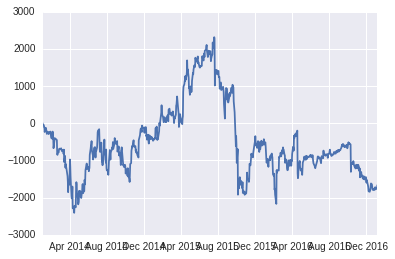

In [220]:
plt.plot(multi_mean)